In [74]:
import pandas as pd

generalData = pd.read_csv(r'data\general_data.csv')
employeeData = pd.read_csv(r'data\employee_survey_data.csv')
csvInTimeData = pd.read_csv(r'data\in_time.csv')
managerData = pd.read_csv(r'data\manager_survey_data.csv')
csvOutTimeData = pd.read_csv(r'data\out_time.csv')

intTimeData = csvInTimeData.rename(columns={'Unnamed: 0': 'EmployeeID'})
outTimeData = csvOutTimeData.rename(columns={'Unnamed: 0': 'EmployeeID'})


In [75]:
allData = pd.merge(employeeData, generalData, how='inner', on=['EmployeeID'])
allData = allData.merge(managerData, how='inner', on=['EmployeeID'])
""" allData = allData.merge(intTimeData, how='inner', on=['EmployeeID'])
allData = allData.merge(outTimeData, how='inner', on=['EmployeeID']) """

allData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4410 entries, 0 to 4409
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   EmployeeID               4410 non-null   int64  
 1   EnvironmentSatisfaction  4385 non-null   float64
 2   JobSatisfaction          4390 non-null   float64
 3   WorkLifeBalance          4372 non-null   float64
 4   Age                      4410 non-null   int64  
 5   Attrition                4410 non-null   object 
 6   BusinessTravel           4410 non-null   object 
 7   Department               4410 non-null   object 
 8   DistanceFromHome         4410 non-null   int64  
 9   Education                4410 non-null   int64  
 10  EducationField           4410 non-null   object 
 11  EmployeeCount            4410 non-null   int64  
 12  Gender                   4410 non-null   object 
 13  JobLevel                 4410 non-null   int64  
 14  JobRole                 

In [76]:
allData.describe()

,EmployeeID,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,DistanceFromHome,Education,EmployeeCount,JobLevel,MonthlyIncome,...,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating
count,4410.000000,4385.000000,4390.000000,4372.000000,4410.000000,4410.000000,4410.000000,4410.0,4410.000000,4410.000000,...,4410.000000,4410.0,4410.000000,4401.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000
mean,2205.500000,2.723603,2.728246,2.761436,36.923810,9.192517,2.912925,1.0,2.063946,65029.312925,...,15.209524,8.0,0.793878,11.279936,2.799320,7.008163,2.187755,4.123129,2.729932,3.153741
std,1273.201673,1.092756,1.101253,0.706245,9.133301,8.105026,1.023933,0.0,1.106689,47068.888559,...,3.659108,0.0,0.851883,7.782222,1.288978,6.125135,3.221699,3.567327,0.711400,0.360742
min,1.000000,1.000000,1.000000,1.000000,18.000000,1.000000,1.000000,1.0,1.000000,10090.000000,...,11.000000,8.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000
25%,1103.250000,2.000000,2.000000,2.000000,30.000000,2.000000,2.000000,1.0,1.000000,29110.000000,...,12.000000,8.0,0.000000,6.000000,2.000000,3.000000,0.000000,2.000000,2.000000,3.000000
50%,2205.500000,3.000000,3.000000,3.000000,36.000000,7.000000,3.000000,1.0,2.000000,49190.000000,...,14.000000,8.0,1.000000,10.000000,3.000000,5.000000,1.000000,3.000000,3.000000,3.000000
75%,3307.750000,4.000000,4.000000,3.000000,43.000000,14.000000,4.000000,1.0,3.000000,83800.000000,...,18.000000,8.0,1.000000,15.000000,3.000000,9.000000,3.000000,7.000000,3.000000,3.000000
max,4410.000000,4.000000,4.000000,4.000000,60.000000,29.000000,5.000000,1.0,5.000000,199990.000000,...,25.000000,8.0,3.000000,40.000000,6.000000,40.000000,15.000000,17.000000,4.000000,4.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022BE3087808>,
      dtype=object)

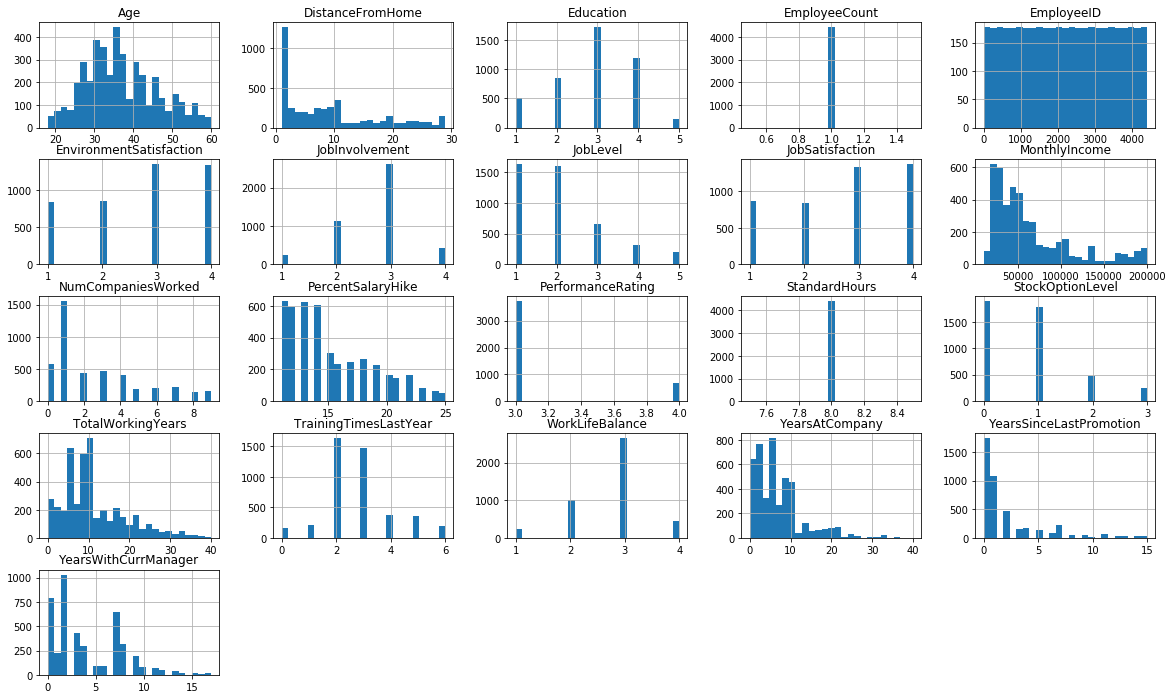

In [82]:
allData.hist(figsize=(20,12), bins=25)

In [83]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

X = allData.copy() # A new copy of data set
X.drop("Attrition", axis=1, inplace=True) # Not numerical
X.drop("BusinessTravel", axis=1, inplace=True) # Not numerical
X.drop("EducationField", axis=1, inplace=True) # Not numerical
X.drop("Department", axis=1, inplace=True) # Not numerical
X.drop("Gender", axis=1, inplace=True) # Not numerical
X.drop("JobRole", axis=1, inplace=True) # Not numerical
X.drop("MaritalStatus", axis=1, inplace=True) # Not numerical
X.drop("Over18", axis=1, inplace=True) # Not numerical

X.head()

,EmployeeID,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,DistanceFromHome,Education,EmployeeCount,JobLevel,MonthlyIncome,...,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating
0,1,3.0,4.0,2.0,51,6,2,1,1,131160,...,11,8,0,1.0,6,1,0,0,3,3
1,2,3.0,2.0,4.0,31,10,1,1,1,41890,...,23,8,1,6.0,3,5,1,4,2,4
2,3,2.0,2.0,1.0,32,17,4,1,4,193280,...,15,8,3,5.0,2,5,0,3,3,3
3,4,4.0,4.0,3.0,38,2,5,1,3,83210,...,11,8,3,13.0,5,8,7,5,2,3
4,5,4.0,1.0,3.0,32,10,1,1,1,23420,...,12,8,2,9.0,2,6,0,4,3,3


In [89]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

num_attribs = list(X)
cat_attribs = ["BusinessTravel", "Attrition", "EducationField", "Department", "Gender", "JobRole", "MaritalStatus", "Over18"]

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

allDataPipeline = num_pipeline.fit_transform(X)

In [101]:
from sklearn.compose import ColumnTransformer

full_pipeline = ColumnTransformer([
        ("num", allDataPipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

ML = full_pipeline.fit_transform(allData)
ML

C:\Users\masso\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:280: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if t in ('drop', 'passthrough'):


TypeError: All estimators should implement fit and transform, or can be 'drop' or 'passthrough' specifiers. '[[-1.7316581   0.25220049  1.15630228 ... -1.15593471  0.37967213
  -0.42623002]
 [-1.73087259  0.25220049 -0.6638987  ... -0.03451975 -1.02616674
   2.34615106]
 [-1.73008708 -0.66545972 -0.6638987  ... -0.31487349  0.37967213
  -0.42623002]
 ...
 [ 1.73008708 -1.58311992  0.24620179 ... -0.59522723  0.37967213
   2.34615106]
 [ 1.73087259  1.1698607  -1.57399919 ...  1.08689522 -1.02616674
  -0.42623002]
 [ 1.7316581  -1.58311992  0.24620179 ...  1.36724896  1.78551099
  -0.42623002]]' (type <class 'numpy.ndarray'>) doesn't.

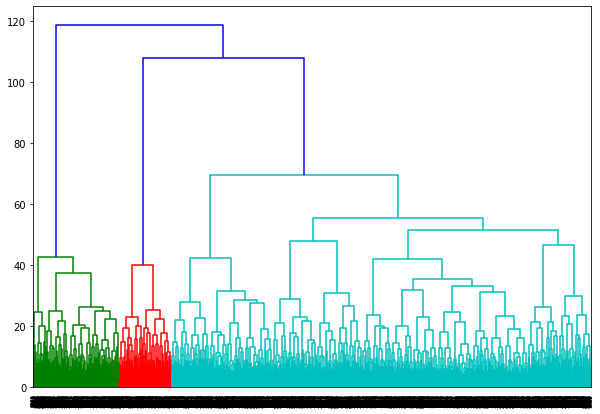

In [102]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
dendrogram(linkage(allDataPipeline, method='ward'), orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.show()